# Integrator RNN Model

In this notebook, we train a vanilla RNN to integrate white noise. This example is useful on its own to understand how RNN training works.

In [1]:
import matplotlib.pyplot as plt

import brainpy as bp
import brainpy.math as bm

bm.set_environment(bm.training_mode)

In [2]:
bp.__version__

'2.4.3'

## Parameters

In [3]:
dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128

## Data

In [4]:
@bm.jit(static_argnames=['batch_size'])
def build_inputs_and_targets(mean=0.025, scale=0.01, batch_size=10):
  # Create the white noise input
  sample = bm.random.normal(size=(batch_size, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(batch_size, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets

In [5]:
def train_data():
  for _ in range(100):
    yield build_inputs_and_targets(batch_size=num_batch)

## Model

In [6]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, x):
    return self.out(self.rnn(x))

model = RNN(1, 100)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Training

In [7]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
  mse = bp.losses.mean_squared_error(predictions, targets)
  l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
  return mse + l2


# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)


# create a trainer
trainer = bp.BPTT(model, loss_fun=loss, optimizer=opt)
trainer.fit(train_data,
            num_epoch=30,
            num_report=200)

Train 200 steps, use 1.9202 s, loss 0.5666112303733826
Train 400 steps, use 1.1134 s, loss 0.024968581274151802
Train 600 steps, use 1.1003 s, loss 0.02216172218322754
Train 800 steps, use 1.1105 s, loss 0.021766066551208496
Train 1000 steps, use 1.1119 s, loss 0.021580681204795837
Train 1200 steps, use 1.1100 s, loss 0.0214251521974802
Train 1400 steps, use 1.1109 s, loss 0.02127397060394287
Train 1600 steps, use 1.1103 s, loss 0.02117355354130268
Train 1800 steps, use 1.1075 s, loss 0.021074647083878517
Train 2000 steps, use 1.0969 s, loss 0.020986948162317276
Train 2200 steps, use 1.0962 s, loss 0.02090354822576046
Train 2400 steps, use 1.1340 s, loss 0.020846327766776085
Train 2600 steps, use 1.2002 s, loss 0.020739112049341202
Train 2800 steps, use 1.1426 s, loss 0.020664572715759277
Train 3000 steps, use 1.0991 s, loss 0.020596308633685112


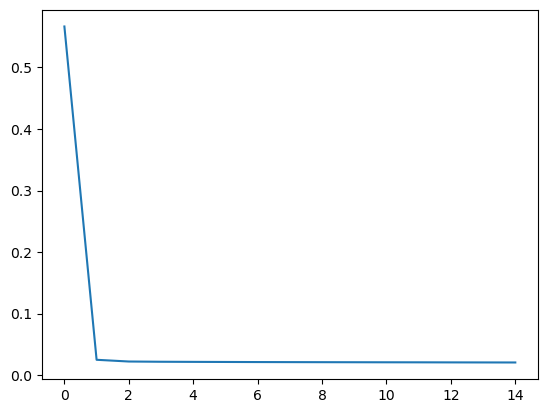

In [8]:
plt.plot(bm.as_numpy(trainer.get_hist_metric()))
plt.show()

## Testing

  0%|          | 0/25 [00:00<?, ?it/s]

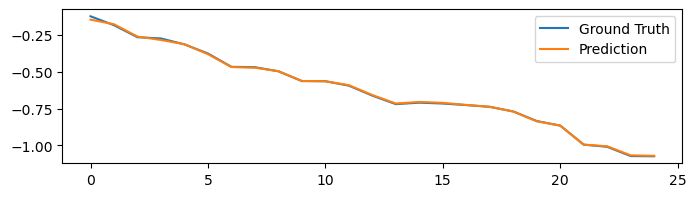

In [9]:
model.reset_state(1)
x, y = build_inputs_and_targets(batch_size=1)
predicts = trainer.predict(x)

plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()